In [1]:
import os
import math
import pandas

import seaborn as sns
import matplotlib.pyplot as plt

from src.data.annotations import load_dataset_annotations
from src.data.annotations import make_continious_labels
from src.visualization.events import legend_without_duplicate_labels
from src.features.soundlevel import compute_background
from src.utils.fileutils import get_project_root

In [2]:
annotations = load_dataset_annotations()
# annotations

skipping archive
skipping MAESTRO_annotation_notes.md
skipping archive
skipping b093_annotations_BD.txt.bak
skipping TUT_annotation_notes.md


In [3]:
def load_noise_classes():
    p = os.path.join(get_project_root(), 'data/processed/noise_classes.csv')
    df = pandas.read_csv(p, sep=';', quotechar="'")
    df['noise'] = df.noise.fillna('other')
    df = df.set_index('original')
    return df

m = load_noise_classes()
m.noise.value_counts()

noise
other           37
speech          16
road_traffic    11
rail_traffic     5
biophony         5
geophony         4
music            2
Name: count, dtype: int64

In [4]:
def make_multitrack_labels(df, classes=None, time_resolution=0.100):
    last = df['end'].max()
    out = make_continious_labels(df, length=math.ceil(last/time_resolution),
                                 time_resolution=time_resolution,
                                 class_column='noise_class',
                                 classes=classes)
    
    return out


aa = annotations.copy()
aa['noise_class'] = aa.annotation.map(m.noise.to_dict())
all_classes = sorted(aa.noise_class.unique())
multi_track = aa.groupby(['dataset', 'clip']).apply(make_multitrack_labels, classes=all_classes)
# multi_track

In [5]:
def single_track_labels(multi : pandas.DataFrame, mixed_class='mixed'):

    classes_active = multi.sum(axis=1)
    out = pandas.Series(['background']*len(multi), index=multi.index, dtype=pandas.StringDtype())

    # Simple definition of mixed: anytime there is any form of overlap in the labels (eg, >= 2)
    out.loc[classes_active >= 2] = mixed_class
    
    out.loc[classes_active == 1] = multi.idxmax(axis=1)
    return out


single_track = multi_track.groupby(['dataset', 'clip'], group_keys=False).apply(single_track_labels)
#single_track

dataset  clip                time                  
maestro  cafe_restaurant_08  0 days 00:00:00             background
                             0 days 00:00:00.100000      background
                             0 days 00:00:00.200000      background
                             0 days 00:00:00.300000      background
                             0 days 00:00:00.400000      background
                                                           ...     
tut      b093                0 days 00:03:30.400000           mixed
                             0 days 00:03:30.500000    road_traffic
                             0 days 00:03:30.600000    road_traffic
                             0 days 00:03:30.700000    road_traffic
                             0 days 00:03:30.800000    road_traffic
Length: 34998, dtype: string

In [6]:
def import_soundlevels(speed: str = 'LAF'):
    return pandas.read_parquet(os.path.join(get_project_root(), f'data/processed/soundlevels/{speed}.parquet'))

In [7]:
def resample_levels(df: pandas.DataFrame, freq='100ms'):
    out = df.copy()
    out = out.reset_index(allow_duplicates=True).set_index('time')
    out = out[['level', 'background', 'delta']]
    
    # isinstance(out.index, pandas.DatetimeIndex)

    return out.resample(freq).mean()

In [8]:
def map_levels_to_labels(single: pandas.DataFrame, speed='LAF'):
    '''
    Imports the saved soundlevels for LAF/LAS, computes background levels, resamples levels
    to match the Timedelta of the single track labels, then renames/relabels instances of "background"
    which are actually sound events.
    '''
    
    soundlevels = import_soundlevels(speed=speed)
    
    # compute background levels and delta
    sb = soundlevels.groupby(['dataset', 'clip'])['level'].apply(compute_background, window=30.0)
    
    # apply resampling then recompute delta
    sb = sb.groupby(['dataset', 'clip'])[['level', 'background', 'delta']].apply(resample_levels)
    sb['delta'] = sb['level'] - sb['background']
    
    # merge the resampled levels with the labels
    df = pandas.DataFrame(single).merge(sb, how='left', left_index=True, right_index=True)
    
    print('Shape:', df.shape)

    # mark timestamps where delta exceeds +5db (sound events)
    df['event'] = df['delta'] >= 5
    
    # print(df['event'].value_counts())
    
    
    # print(df[0].value_counts())
    
    # if a timestamp is NOT an event, label it as background
    df[0] = df[0].where(df['event'], other='background')
    
    # print(df[0].value_counts())

    # if a timestamp is labelled as "background", but also a sound event - re-label to "unknown"
    df['unknown'] = (df[0] == 'background') & (df['event'] == True)
    df[0] = df[0].mask(df['unknown'], other='unknown')
    
    # print(df[0].value_counts())

    df = df.rename(columns={0: 'label'})
    
    df = df[['label', 'level', 'background', 'delta']]

    return df
    

### Import soundlevels and map to labels

In [9]:
LAF = map_levels_to_labels(single = single_track, speed='LAF')

Shape: (34998, 4)


In [10]:
LAS = map_levels_to_labels(single = single_track, speed='LAS')

Shape: (34998, 4)


In [37]:
speed_dict = {'LAF': LAF, 'LAS': LAS}

In [43]:
def plot_overall_distributions(speed='LAF'):
    df = speed_dict[speed]
    sns.set_style("whitegrid")
    fig, ax = plt.subplots()
    ax = df['label'].value_counts(normalize=True).mul(100).plot(kind='barh')
    ax.set_title(f'Overall {speed} Label Distribution')
    return ax

In [54]:
LAF_values = LAF['label'].value_counts(normalize=True).mul(100)

In [55]:
LAF_values

label
background      71.986971
road_traffic    14.752272
unknown          3.771644
mixed            3.348763
rail_traffic     2.634436
speech           1.840105
other            1.225784
biophony         0.268587
geophony         0.108578
music            0.062861
Name: proportion, dtype: Float64

In [56]:
LAS_values = LAS['label'].value_counts(normalize=True).mul(100)
LAS_values

label
background      89.942282
road_traffic      5.64318
unknown          1.597234
rail_traffic     1.051489
mixed            0.868621
speech           0.457169
other            0.288588
biophony         0.100006
music            0.025716
geophony         0.025716
Name: proportion, dtype: Float64

## What is the overall proportion of Sound Event Activations per LAF/LAS configuration?

In [102]:
LAF_bck = round(LAF_values['background'], 2)
LAF_sed_to_background = (round(100-LAF_bck, 2), LAF_bck)

LAF_sed_to_background

In [107]:
LAS_bck = round(LAS_values['background'], 2)
LAS_sed_to_background = (round(100-LAS_bck, 2), LAS_bck)

LAS_sed_to_background

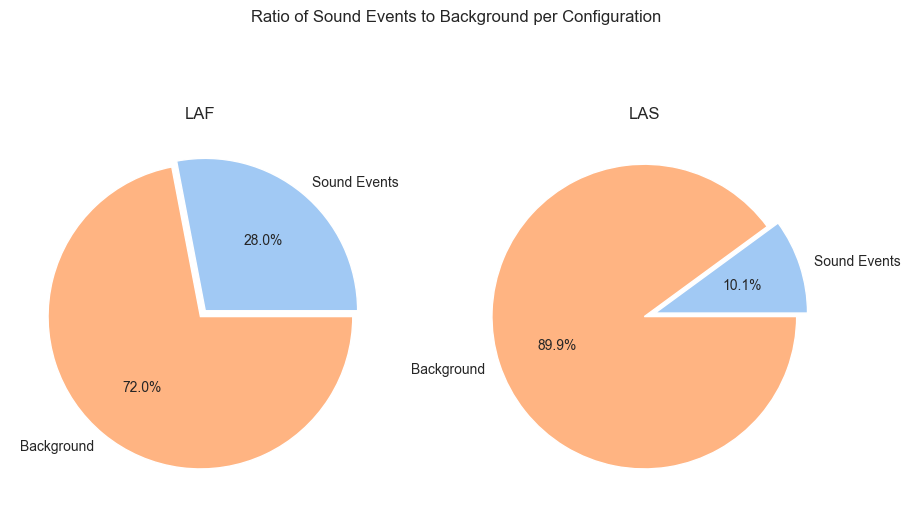

In [167]:
colors = sns.color_palette('pastel')[0:2]
fig = plt.figure(figsize=(9,6), constrained_layout=True)
#1 row 2 columns
fig.suptitle('Ratio of Sound Events to Background per Configuration')
#first row, first column
ax1 = plt.subplot2grid((1,2),(0,1))
explode = [0.075, 0]
plt.pie(LAS_sed_to_background, labels=['Sound Events', 'Background'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAS')

#first row sec column
ax1 = plt.subplot2grid((1,2),(0,0))
explode = [0.05, 0]
plt.pie(LAF_sed_to_background, labels=['Sound Events', 'Background'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAF')

plt.show()

## Why does the proportion differ between LAF/LAS configurations?

ANSWER:

## Of the Sound Events, how are the labels distributed?

ANSWER:

In [130]:
LAF_events = LAF['label'].loc[LAF['label'] != 'background'].value_counts(normalize=True).mul(100)

LAF_events

label
road_traffic    52.662179
unknown         13.463892
mixed           11.954304
rail_traffic     9.404325
speech           6.568747
other            4.375765
biophony         0.958792
geophony         0.387597
music            0.224398
Name: proportion, dtype: Float64

In [123]:
LAS_events = LAS['label'].loc[LAS['label'] != 'background'].value_counts(normalize=True).mul(100)

LAS_events

label
road_traffic    56.107955
unknown         15.880682
rail_traffic    10.454545
mixed            8.636364
speech           4.545455
other            2.869318
biophony         0.994318
music            0.255682
geophony         0.255682
Name: proportion, dtype: Float64

In [132]:
colors = dict(zip(LAS_events.index, sns.color_palette("pastel")[:len(LAS_events.index)]))

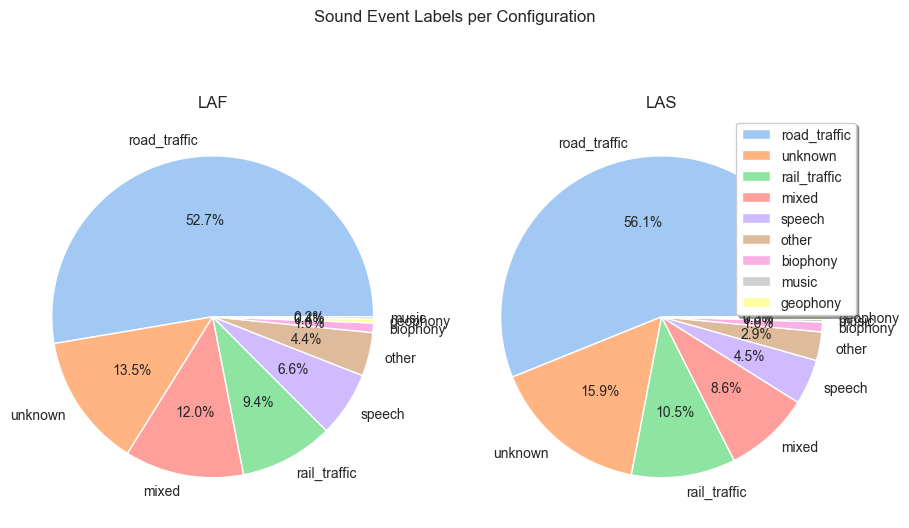

In [142]:
# from matplotlib import colormaps
# colors = { label: color  for label, color in zip(LAS_events.index, colormaps['Dark2'].colors)}
# colors = dict(zip(LAS_events.index, sns.color_palette("pastel")[:len(LAS_events.index)]))

fig = plt.figure(figsize=(9,6), constrained_layout=True)
#1 row 2 columns
fig.suptitle('Sound Event Labels per Configuration')
#first row, first column
ax1 = plt.subplot2grid((1,2),(0,1))
plt.pie(LAS_events, labels=LAS_events.index, autopct='%1.1f%%', colors=[colors[v] for v in LAS_events.index])
plt.title('LAS')

#first row sec column
ax2 = plt.subplot2grid((1,2),(0,0))
plt.pie(LAF_events, labels=LAF_events.index, autopct='%1.1f%%', colors=[colors[v] for v in LAF_events.index])
plt.title('LAF')

ax1.legend(loc='upper right', shadow=True)


plt.show()

## Of the Sound Events that have been labelled, what is the proportion of "mixed" to "single" sources?

In [155]:
# keep "mixed" the same, drop "unknown" then roll up the rest of the labels into "single" label

LAF_events = LAF['label'].loc[(LAF['label'] != 'background') & (LAF['label'] != 'unknown')].value_counts(normalize=True).mul(100)
LAF_mixed = round(LAF_events.loc['mixed'], 2)
LAF_single = round((100-LAF_mixed), 2)



LAS_events = LAS['label'].loc[(LAS['label'] != 'background') & (LAS['label'] != 'unknown')].value_counts(normalize=True).mul(100)
LAS_mixed = round(LAS_events.loc['mixed'], 2)
LAS_single = round((100-LAS_mixed), 2)
LAS_single

89.73

In [156]:
LAS_events

label
road_traffic    66.700439
rail_traffic    12.428234
mixed           10.266802
speech            5.40358
other             3.41101
biophony         1.182033
music            0.303951
geophony         0.303951
Name: proportion, dtype: Float64

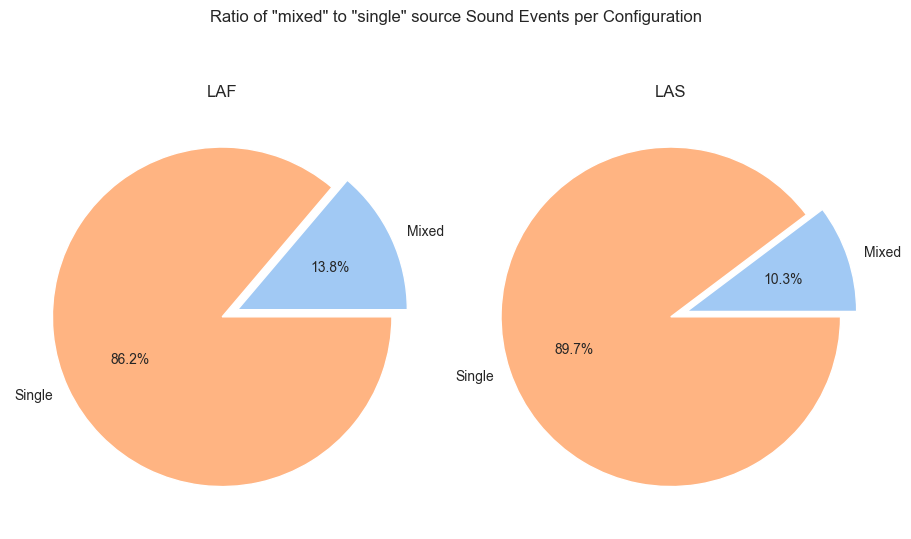

In [169]:
colors = sns.color_palette('pastel')[0:2]
fig = plt.figure(figsize=(9,6), constrained_layout=True)
#1 row 2 columns
fig.suptitle('Ratio of "mixed" to "single" source Sound Events per Configuration')
explode=[0.1, 0]
#first row, first column
ax1 = plt.subplot2grid((1,2),(0,1))
plt.pie([LAS_mixed, LAS_single], labels=['Mixed', 'Single'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAS')

#first row sec column
ax1 = plt.subplot2grid((1,2),(0,0))
plt.pie([LAF_mixed, LAF_single], labels=['Mixed', 'Single'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAF')

plt.show()

## Why does the "fast" configuration pick up more "mixed" sources?

Fast picks up all the intermittant percusives etc

## For this dataset, what is the proportion of Sound Events that have not been labelled?

In [161]:
# keep "unknown" then roll up the rest of the labels into a "labelled" label

LAF_events = LAF['label'].loc[(LAF['label'] != 'background')].value_counts(normalize=True).mul(100)
LAF_unk = round(LAF_events.loc['unknown'], 2)
LAF_knw = round((100-LAF_unk), 2)



LAS_events = LAS['label'].loc[(LAS['label'] != 'background')].value_counts(normalize=True).mul(100)
LAS_unk = round(LAS_events.loc['unknown'], 2)
LAS_knw = round((100-LAS_unk), 2)
LAS_knw

84.12

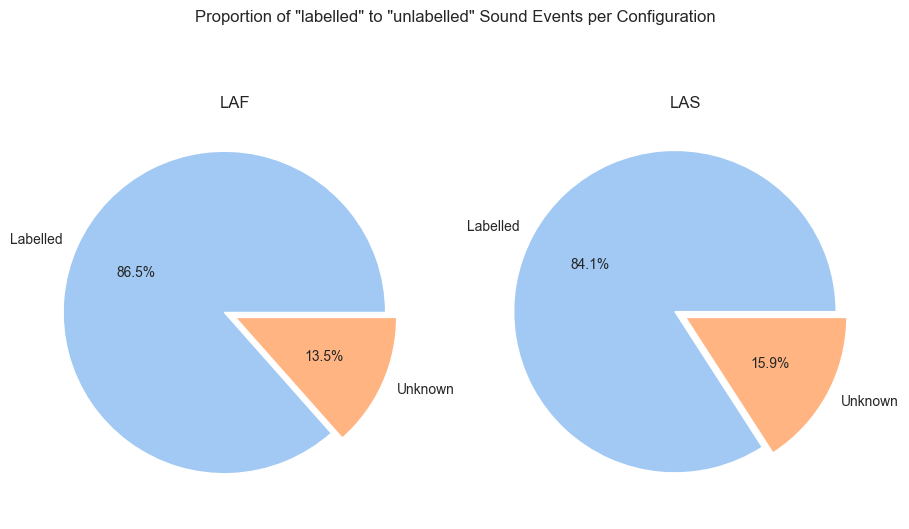

In [172]:
colors = sns.color_palette('pastel')[0:2]
fig = plt.figure(figsize=(9,6), constrained_layout=True)
#1 row 2 columns
fig.suptitle('Proportion of "labelled" to "unlabelled" Sound Events per Configuration')
explode=[0.075, 0]
#first row, first column
ax1 = plt.subplot2grid((1,2),(0,1))
plt.pie([LAS_knw, LAS_unk], labels=['Labelled', 'Unknown'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAS')

#first row sec column
ax1 = plt.subplot2grid((1,2),(0,0))
plt.pie([LAF_knw, LAF_unk], labels=['Labelled', 'Unknown'], autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('LAF')

plt.show()

## How are Sound Events distributed across different clips?

In [21]:
def dense_to_events(df : pandas.DataFrame,
                    category_column='label',
                    time_column='time',
                   ) -> pandas.DataFrame:
    """
    Convert a dense time-series with categories into events with start,end
    """
    df = df.copy() # avoid mutating input
    df['start'] = df[time_column]
    df['end'] = df[time_column]
    changes = df[category_column].ne(df[category_column].shift()).dropna()
    label_groups = changes.cumsum()

    out = df.groupby(label_groups).agg({'start':'min', 'end':'max', category_column:'first'}).reset_index(drop=True)

    return out

In [22]:
from src.visualization.events import plot_events

class_color_map = {
    'background': (0.95, 0.95, 0.95),
    'mixed': 'black',
    'speech': 'blue',
    'music': 'green',
    'rail_traffic': 'red',
    'road_traffic': 'orange',
    'other': 'teal',
    'biophony': 'yellow',
    'geophony': 'purple',
    'unknown': 'magenta'
}

def plot(s):
    
    s = s['label']

    fig, ax = plt.subplots(1, figsize=(15, 2))

    # A) convert back to indicator columns. Use existing multi track plotting
    # will make switches clear - but not obvious that the classes are mutually exclusive
    multi = pandas.get_dummies(s)
    multi = multi.reset_index().set_index('time').drop(columns=['dataset', 'clip'])    
    #plot_multitrack_labels(ax, multi)


    # B) group into runs. Use vspan to plot colored sections
    df = s.to_frame()
    df.columns = ['label']
    df = df.reset_index()
    df['time'] = df.time / pandas.Timedelta(seconds=1) # matplotlib / plot_events() does not like Timedeltas
    df = df.drop(columns=['dataset', 'clip'])

    cons = dense_to_events(df)
    cons['color'] = cons.label.map(class_color_map)
    
    plot_events(ax, cons, color='color', label='label', alpha=1.0)
    legend_without_duplicate_labels(ax)

""


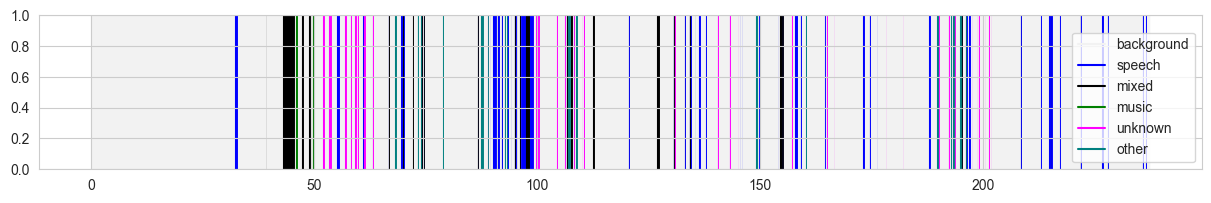

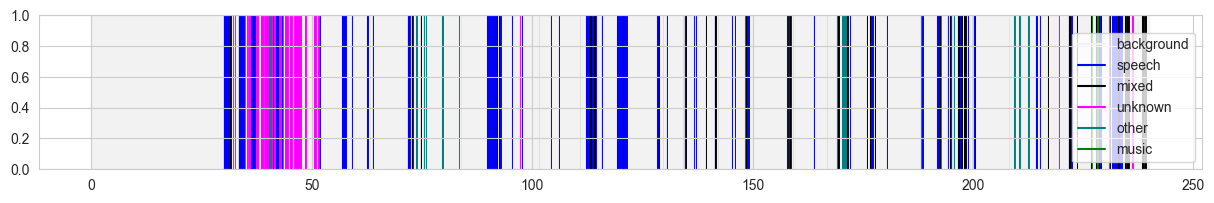

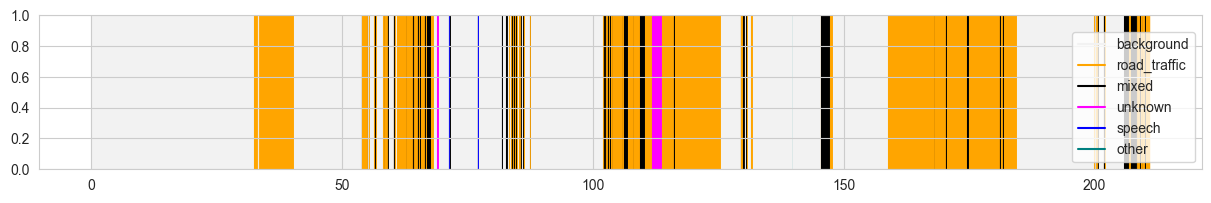

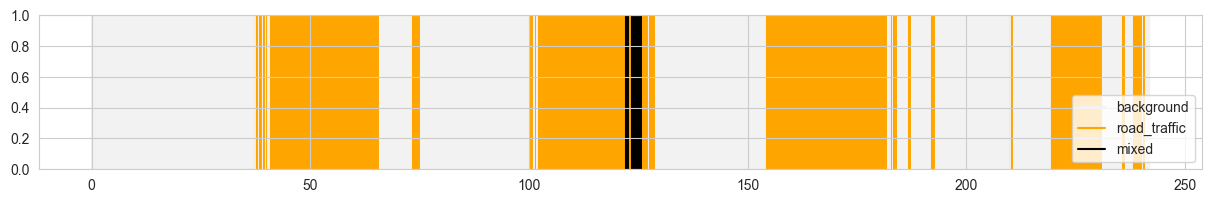

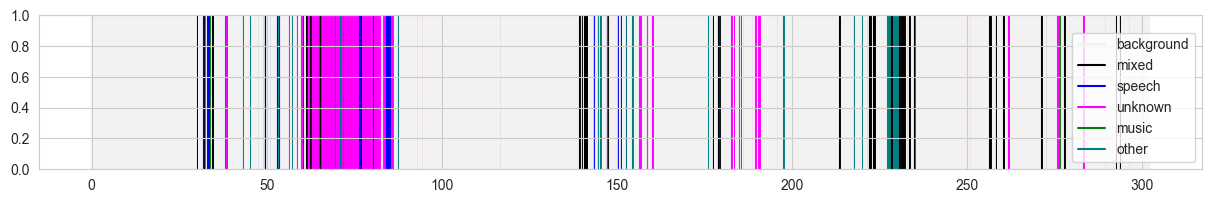

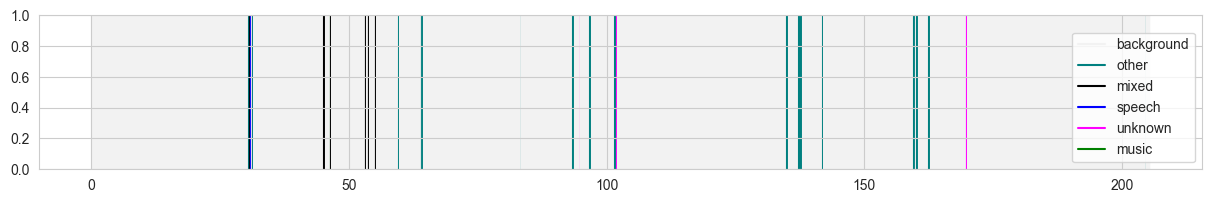

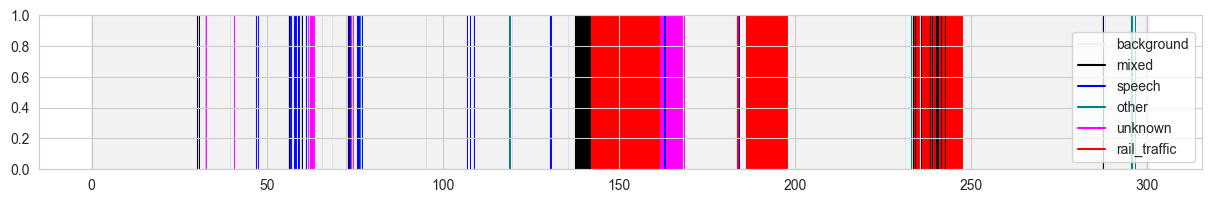

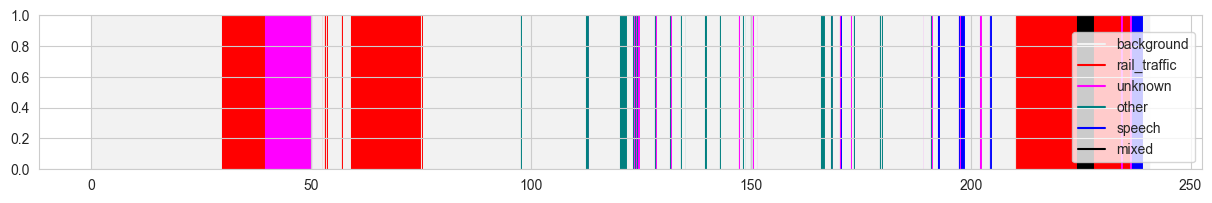

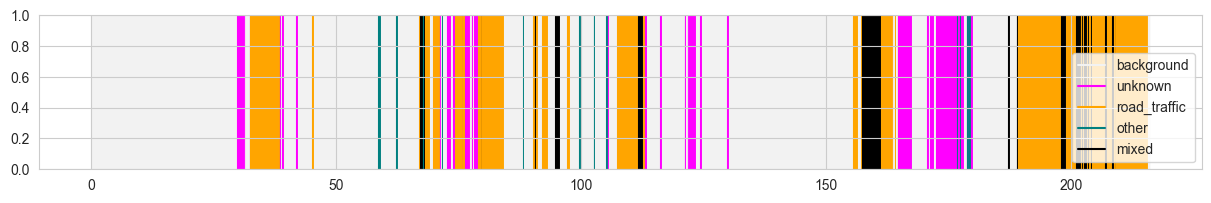

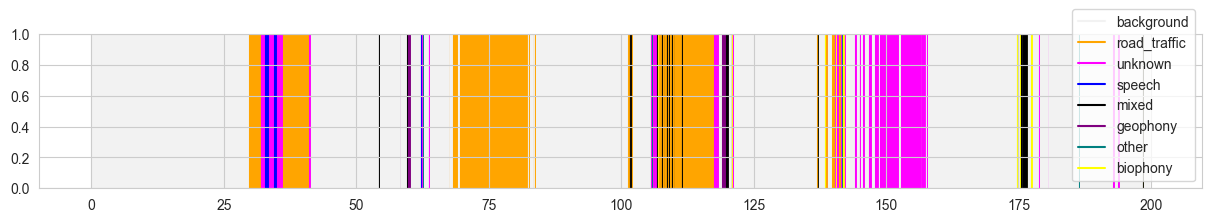

In [23]:
MAESTRO_LAF = LAF.loc[['maestro']]
MAESTRO_LAF.groupby(['dataset', 'clip']).apply(plot)

""


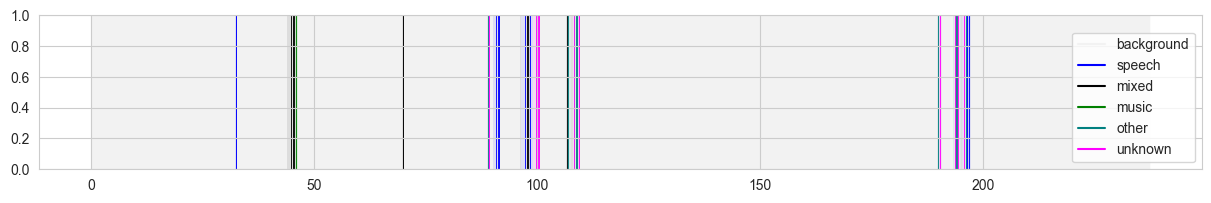

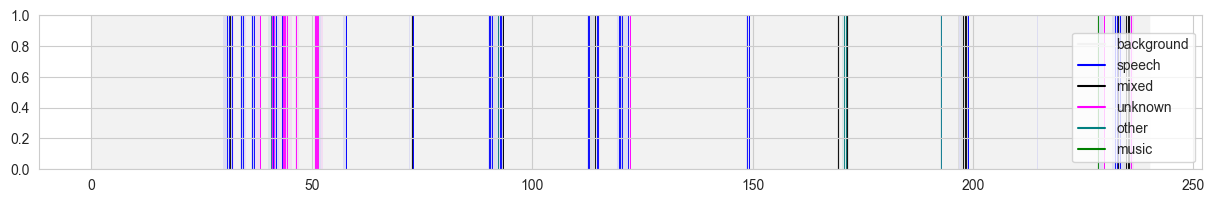

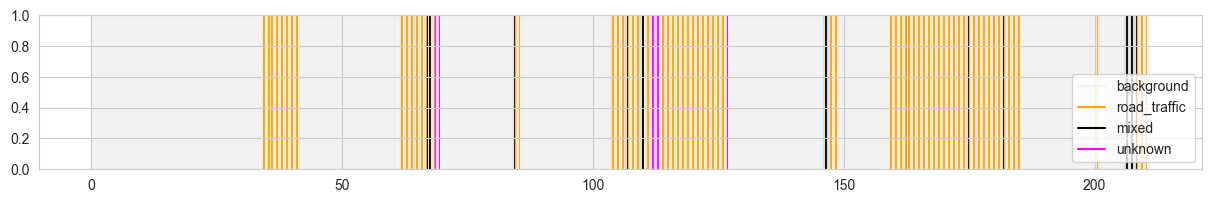

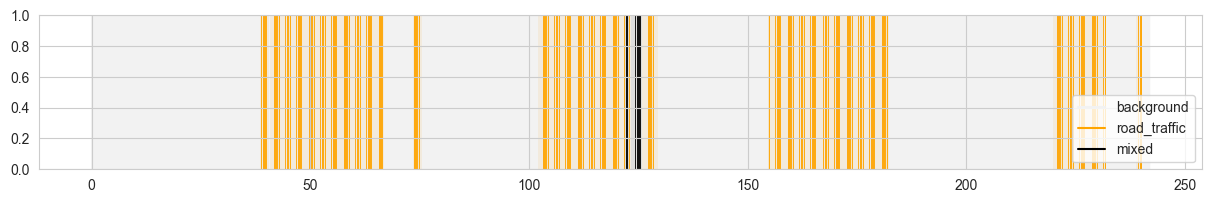

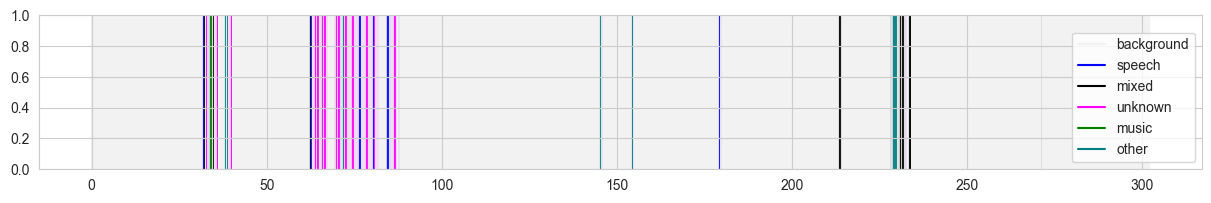

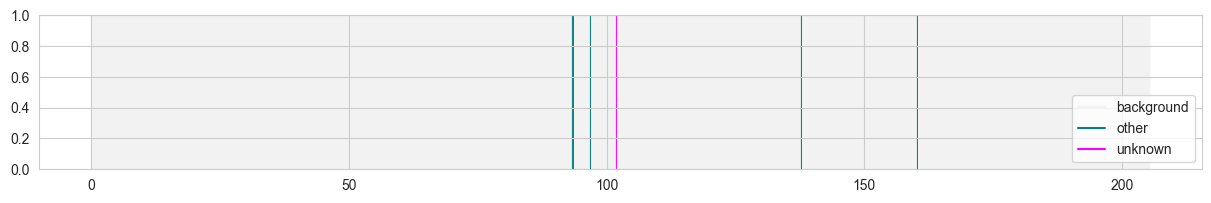

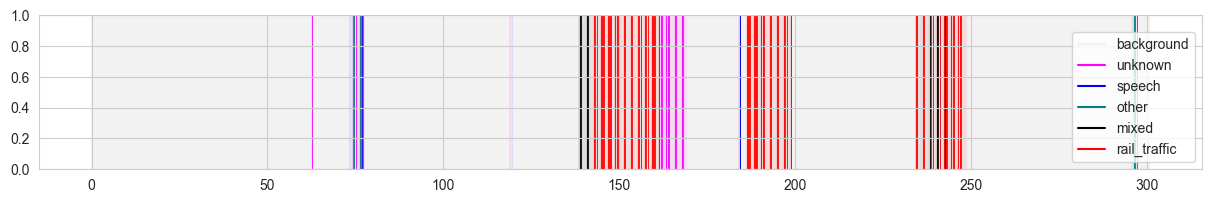

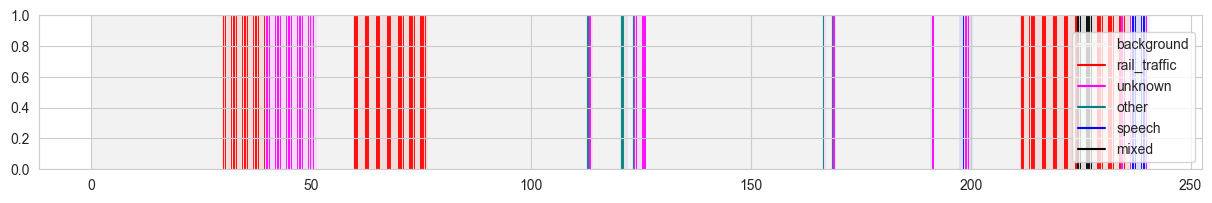

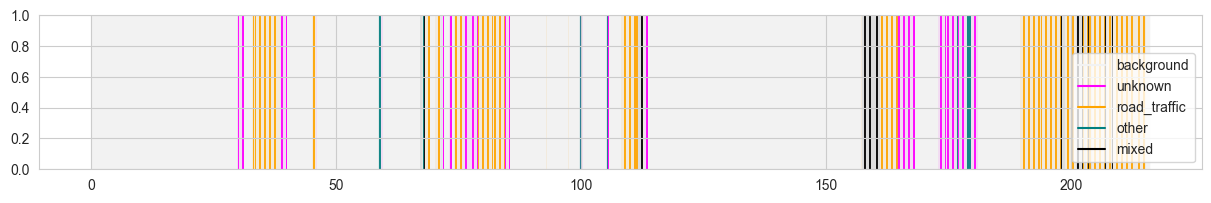

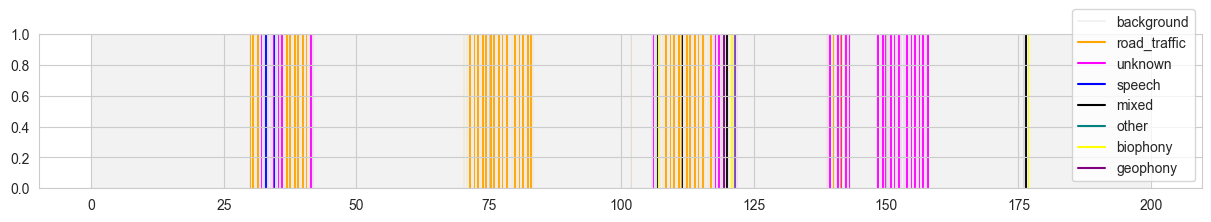

In [24]:
MAESTRO_LAS = LAS.loc[['maestro']]
MAESTRO_LAS.groupby(['dataset', 'clip']).apply(plot)

## Differences between LAF and LAS implementations

ANSWER